A notebook to test the calculation of the buuoyancy frequency as implemented in froude.py.

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import froude
import os
import numpy as np
import datetime

%matplotlib inline

Load some data to experiment with

In [2]:
path = '/data/nsoontie/MEOPAR/SalishSea/results/2Ddomain/3.6'
directory = 'base_aug'
file_part = 'SalishSea_1d_20030819_20030927_{}.nc'

dT = nc.Dataset(os.path.join(path,directory,file_part.format('grid_T')))
sal = dT.variables['vosaline'][:]
sal = np.ma.masked_values(sal,0)
deps = dT.variables['deptht'][:]
temp = dT.variables['votemper'][:]
temp = np.ma.masked_values(temp,0)
ssh = dT.variables['sossheig'][:]
n2 = dT.variables['buoy_n2'][:]
n2 = np.ma.masked_values(n2,0)
times = dT.variables['time_counter'][:]
time_origin = datetime.datetime.strptime(dT.variables['time_counter'].time_origin, '%Y-%m-%d %H:%M:%S')

dU = nc.Dataset(os.path.join(path,directory,file_part.format('grid_U')))
U = dU.variables['vozocrtx'][:]
U = np.ma.masked_values(U,0)
depsU=dU.variables['depthu'][:]

dW = nc.Dataset(os.path.join(path,directory,file_part.format('grid_W')))
avt = dW.variables['vert_eddy_diff'][:]
avt = np.ma.masked_values(avt,0)
avm = dW.variables['vert_eddy_visc'][:]
avm = np.ma.masked_values(avm,0)
depsW=dW.variables['depthw'][:]
diss = dW.variables['dissipation'][:]
diss = np.ma.masked_values(diss,0)




Load the mesh_mask file for scale factors

In [3]:
mesh = nc.Dataset('/data/nsoontie/MEOPAR/2Ddomain/grid/mesh_mask.nc')

e3w = mesh.variables['e3w'][0,:,:,:] # NEMO uses e3w.

In [4]:
rho = froude.calculate_density(temp, sal)

Calculate buoyancy frequency with froude module

In [5]:
reload(froude)

<module 'froude' from 'froude.pyc'>

In [6]:
n2_f = froude.calculate_buoyancy_frequency(temp, sal, e3w, 1)
n2_f = np.ma.masked_values(n2_f,0)

Plot n2_f to see that it makes sense. 

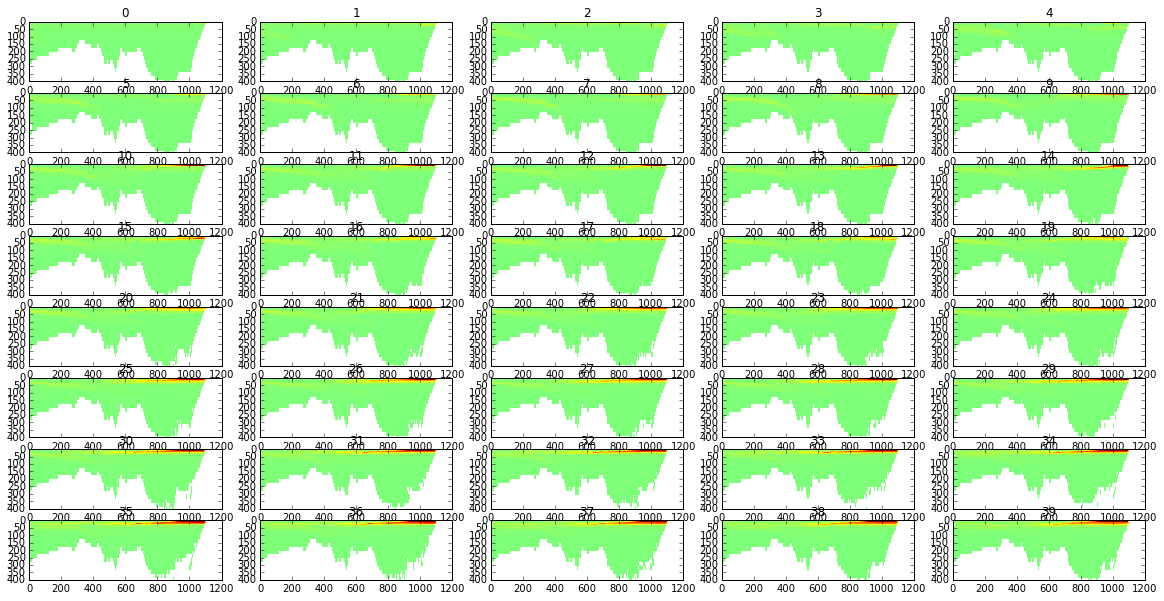

In [7]:
yslice=5
fig, axs = plt.subplots(8,5,figsize=(20,10))
for t, ax in zip (np.arange(times.shape[0]), axs.flat):
    ax.pcolor(np.arange(n2_f.shape[-1]),deps,n2_f[t,:,yslice,:],vmin=-0.01,vmax = 0.01)
    ax.set_title(t)
    ax.set_ylim([400,0])

Compare with NEMO's buoyancy frequency.

In [8]:
diff = n2-n2_f;

print np.ma.max(diff)
print np.ma.min(diff)
print np.ma.mean(diff)

0.0637975778828
-0.0582721825923
-9.82715828842e-05


In [9]:
ind = np.unravel_index(np.ma.argmax(diff), diff.shape)
ind

(0, 4, 4, 1098)

In [10]:
for t in np.arange(times.shape[0]):
    max = np.ma.max(diff[t,...])
    ind = np.unravel_index(np.ma.argmax(diff[t,...]), diff[t,:,:,:].shape)
    print t, ind, max

0 (4, 4, 1098) 0.0637975778828
1 (4, 4, 1098) 0.0608109813299
2 (4, 3, 1098) 0.0397740351603
3 (4, 6, 1098) 0.0209874000337
4 (5, 4, 1098) 0.00988855767693
5 (5, 3, 1098) 0.00900880743467
6 (5, 2, 1098) 0.00978058835956
7 (9, 7, 1098) 0.0110632234048
8 (9, 7, 1098) 0.0124031425429
9 (9, 6, 1098) 0.012225554126
10 (9, 7, 1098) 0.0116716421533
11 (9, 7, 1098) 0.0125277705359
12 (9, 2, 1098) 0.0118110675493
13 (9, 6, 1098) 0.0117886870289
14 (9, 3, 1098) 0.0107564743981
15 (5, 7, 1098) 0.0112179594198
16 (5, 3, 1098) 0.0144991979914
17 (9, 3, 1098) 0.00875587577357
18 (9, 3, 1098) 0.0106275686009
19 (9, 4, 1098) 0.012333180511
20 (9, 7, 1098) 0.0118250392402
21 (9, 4, 1098) 0.0129439677513
22 (9, 7, 1098) 0.0125979529458
23 (9, 6, 1098) 0.0126424818841
24 (9, 3, 1098) 0.0113636432119
25 (9, 6, 1098) 0.0125236500263
26 (9, 6, 1098) 0.0125499353037
27 (9, 2, 1098) 0.0117528877319
28 (9, 4, 1098) 0.011401231538
29 (9, 5, 1098) 0.0112679367465
30 (9, 5, 1098) 0.0102891201313
31 (9, 2, 1098) 0

I think the major differences have to do with the vertical stretching of the grid due to vvl. This is largest at the right side of the domain. I'm not particularly interated in the buoyany frequency in that location, so can I neglec this? Probably. 

What do the differences look like elsewhere?

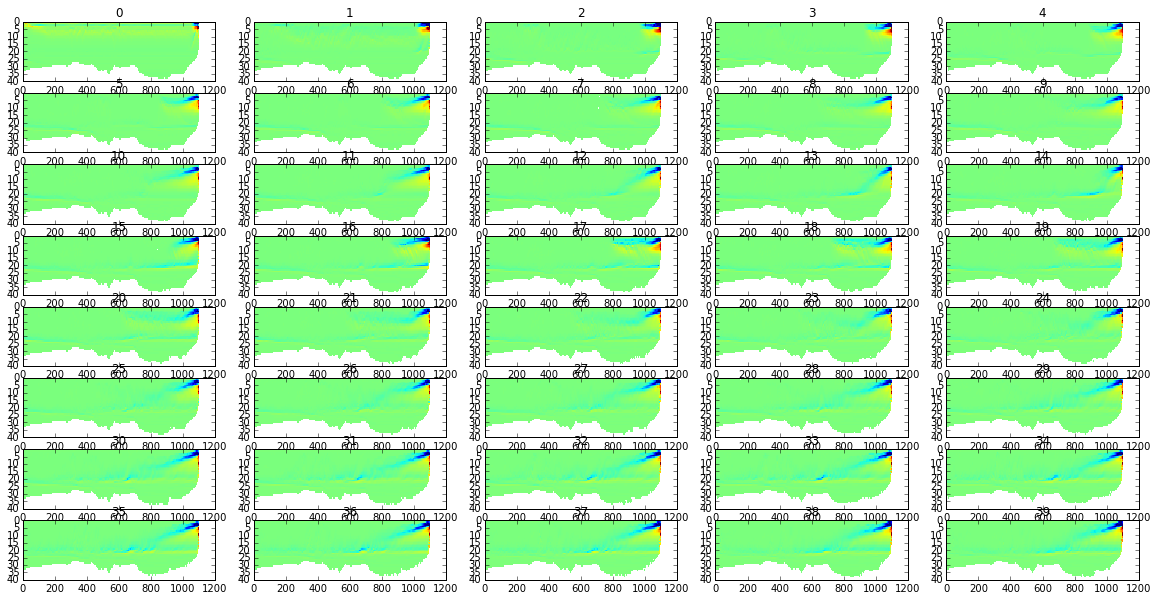

In [11]:
yslice=5
fig, axs = plt.subplots(8,5,figsize=(20,10))
for t, ax in zip (np.arange(times.shape[0]), axs.flat):
    ax.pcolor(diff[t,:,yslice,:],vmin=-0.01,vmax = 0.01)
    ax.set_title(t)
    ax.set_ylim([40,0])

How do these differences affect my Froude number calculations?

In [12]:
n2_f_slice= n2_f[:,:,yslice,:]
rho_slice = rho[:,:,yslice,:]
u_slice = U[:,:,yslice,:]

n2_slice= n2[:,:,yslice,:]


Fr_mys, cs, uvgs, dates = froude.froude_time_series(n2_f_slice,rho_slice,u_slice,
                                                   deps,depsU,times, time_origin)
Fr_NEMO, cs, uvgs, dates = froude.froude_time_series(n2_slice,rho_slice,u_slice,
                                                   deps,depsU,times, time_origin)

/home/nsoontie/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


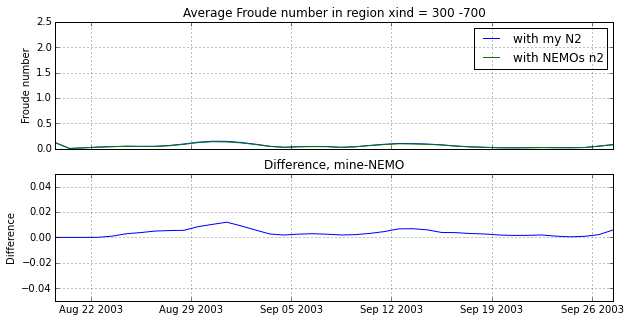

In [13]:
xmin = 300; xmax=700
fig,axs = plt.subplots(2,1,figsize=(10,5),sharex=True)
ax=axs[0]
ax.plot(dates,Fr_mys, label = 'with my N2')
ax.plot(dates,Fr_NEMO, label = 'with NEMOs n2')
ax.set_ylabel('Froude number')
ax.set_title('Average Froude number in region xind = {} -{}'.format(xmin,xmax))
ax.set_ylim([0,2.5])
ax.grid()
ax.legend(loc=0)
ax=axs[1]
ax.plot(dates,np.array(Fr_mys)-np.array(Fr_NEMO))
ax.set_ylabel('Difference')
ax.set_title('Difference, mine-NEMO')
ax.set_ylim([-.05,.05])
ax.grid()

Differences are so small that I'm not going to worry about it. I'm interested in Froude numbers around 1. Calculating buoyancy frequency my own way doens't affect the results to the precision I need. But in the future, I should output n2 as part of the simulation. 